## Suspots Dataset 
This notebook show a time series model ,built using DNN used for predicting future seasonality of the Susposts dataset depending on its past seasonality.
Link for Dataset : https://www.kaggle.com/robervalt/sunspots

In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

Function for ploting the graphs.

In [38]:
def plot_series(time, series, format='-',start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

Reading the CSV file, then tranforming the dataset to have 2 columns "series" and "time" which are numpy array and then finally plotting the dataset to analysis the data and look for trends and seasonalities

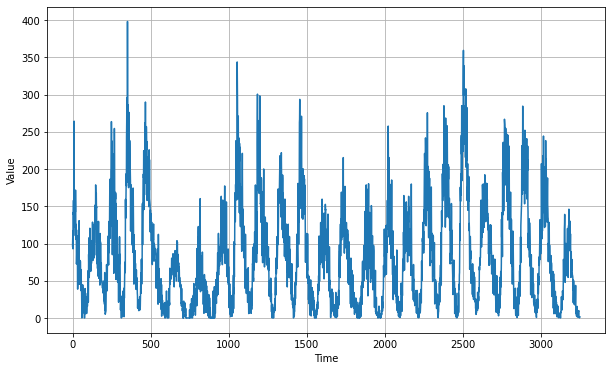

In [39]:
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
  
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [40]:
print("Head of the Data")
print(pd.DataFrame(series,time).head())
print()
print("Tail of the Data")
print(pd.DataFrame(series,time).tail())

Head of the Data
       0
0   96.7
1  104.3
2  116.7
3   92.8
4  141.7

Tail of the Data
        0
3247  0.5
3248  1.1
3249  0.4
3250  0.5
3251  1.6


Splitting the series and time columns, basically the whole dataset into train and validation sets. The splitting is at "time = 3000".In short the data before "time = 3000" is the training_set and the data after that is the validation_set.

In [41]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


The ***windowed_dataset*** is a function that coverts the series data in a data frame structure which be fed to the model for training.

In [42]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Assigning the value to window_size, batch_size, and buffer_size.
Lastly creating the DNN model. 

In [43]:
window_size = 60
batch_size = 32 
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size,
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(40, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=1e-7,momentum=0.9))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 2,861
Trainable params: 2,861
Non-trainable params: 0
_________________________________________________________________


Fitting the training set (***dataset***) to the model.

In [44]:
model.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
92/92 [==============================] - 0s 5ms/step - loss: 3161.9055
Epoch 2/20
92/92 [==============================] - 1s 6ms/step - loss: 1097.7136
Epoch 3/20
92/92 [==============================] - 0s 5ms/step - loss: 994.9700
Epoch 4/20
92/92 [==============================] - 1s 6ms/step - loss: 926.9418
Epoch 5/20
92/92 [==============================] - 0s 5ms/step - loss: 881.1395
Epoch 6/20
92/92 [==============================] - 0s 5ms/step - loss: 844.7160
Epoch 7/20
92/92 [==============================] - 0s 4ms/step - loss: 812.8209
Epoch 8/20
92/92 [==============================] - 0s 5ms/step - loss: 785.2858
Epoch 9/20
92/92 [==============================] - 1s 6ms/step - loss: 756.3847
Epoch 10/20
92/92 [==============================] - 0s 5ms/step - loss: 739.3942
Epoch 11/20
92/92 [==============================] - 0s 4ms/step - loss: 724.7479
Epoch 12/20
92/92 [==============================] - 0s 5ms/step - loss: 712.9550
Epoch 13/20
92/92 [====

Forecasting values using the model.The predictions are based on the features and seasonality learned by the model from the training set and then predicting future values based on the past data. The predicted value is plotted along with the validation_set inorder to get an idea about the efficiency of the model.

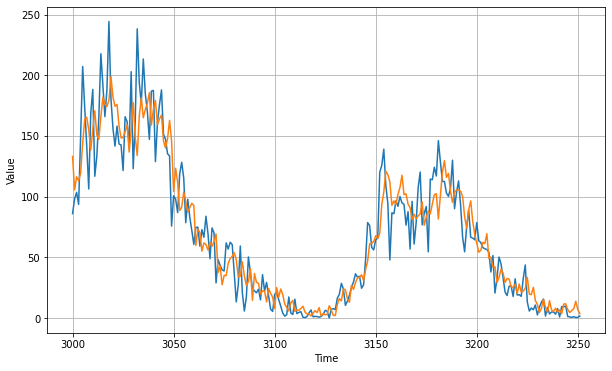

In [45]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Mean Absolute Error.

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


14.8607235